In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR = '/content/drive/MyDrive/MLDataset/WasteImagesDataset'

In [ ]:
!ls -l {DIR}

total 36
drwx------ 2 root root 4096 Mar  6 11:25  Aluminium
drwx------ 2 root root 4096 Mar  6 11:25  Carton
drwx------ 2 root root 4096 Mar  6 11:25  Glass
drwx------ 2 root root 4096 Mar  6 11:25 'Organic Waste'
drwx------ 2 root root 4096 Mar  6 11:25 'Other Plastics'
drwx------ 2 root root 4096 Mar  6 11:25 'Paper and Cardboard'
drwx------ 2 root root 4096 Mar  6 11:25  Plastic
drwx------ 2 root root 4096 Mar  6 11:25  Textiles
drwx------ 2 root root 4096 Mar  6 11:25  Wood


In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                    subset="training", seed=42,
                                                                    batch_size=16)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1,
                                                                  subset="validation", seed=42,
                                                                  batch_size=16)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.


In [ ]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood'] 9


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False

last_output = baseModel.layers[-1].output

234698864/234698864 [==============================] - 11s 0us/step


In [ ]:
x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

In [ ]:
epochs=5
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)

In [ ]:
train_history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callbacks])

Epoch 1/5
286/286 [==============================] - 1530s 5s/step - loss: 0.8902 - accuracy: 0.7642 - val_loss: 0.4928 - val_accuracy: 0.8481
Epoch 2/5
286/286 [==============================] - 50s 172ms/step - loss: 0.1604 - accuracy: 0.9477 - val_loss: 0.4686 - val_accuracy: 0.8757
Epoch 3/5
286/286 [==============================] - 51s 177ms/step - loss: 0.0479 - accuracy: 0.9838 - val_loss: 0.4869 - val_accuracy: 0.8994
Epoch 4/5
286/286 [==============================] - 52s 179ms/step - loss: 0.0279 - accuracy: 0.9910 - val_loss: 0.4331 - val_accuracy: 0.9112
Epoch 5/5
286/286 [==============================] - 57s 199ms/step - loss: 0.0286 - accuracy: 0.9910 - val_loss: 0.5079 - val_accuracy: 0.9034


In [ ]:
model.evaluate(test_dataset)

32/32 [==============================] - 5s 143ms/step - loss: 0.5079 - accuracy: 0.9034


[0.5079397559165955, 0.9033530354499817]

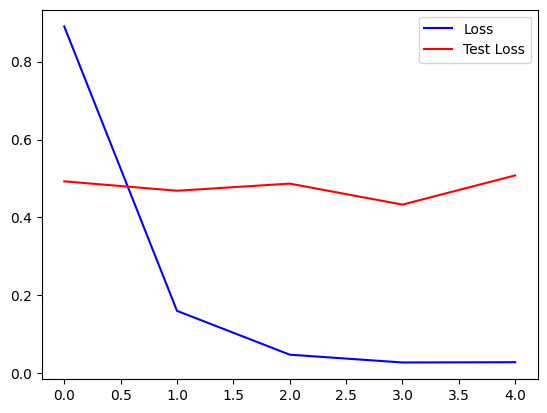

In [ ]:
plt.plot(range(0, epochs), train_history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), train_history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

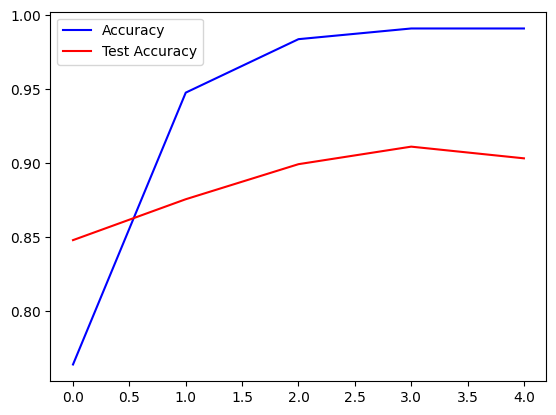

In [ ]:
plt.plot(range(0, epochs), train_history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), train_history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

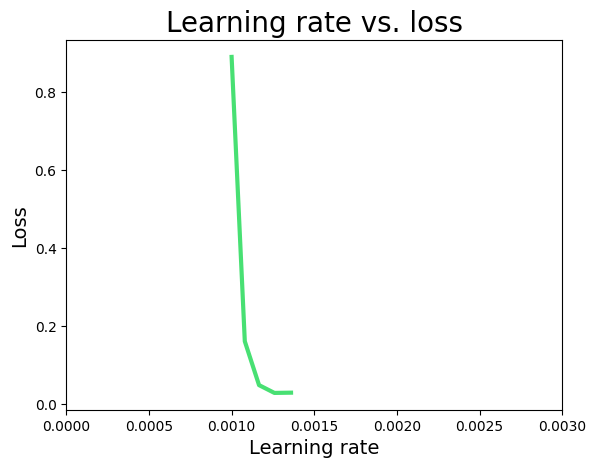

In [ ]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, train_history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 9s 9s/step
[[1.3657451e-09 4.3637897e-08 1.2687669e-10 3.3726848e-09 2.0473618e-09
  9.9998105e-01 6.7613803e-10 3.4471825e-10 1.8902763e-05]]
Prediction: Paper and Cardboard
Prediction: 5
[1.3657451e-07 4.3637897e-06 1.2687669e-08 3.3726849e-07 2.0473618e-07
 9.9998108e+01 6.7613804e-08 3.4471825e-08 1.8902763e-03] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


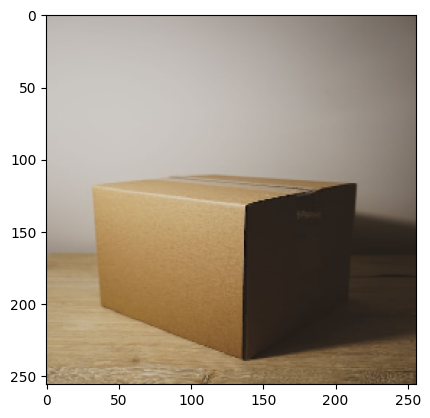

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img

url = "https://images.unsplash.com/photo-1577705998148-6da4f3963bc8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8Nnx8Y2FyZGJvYXJkfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
image = tf.keras.utils.get_file("Image1.jpg", origin=url)

img = load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
#score = tf.nn.softmax(predictions[0])

plt.imshow(img)
print(predictions)
print("Prediction: " + str(classes[np.argmax(predictions)]))
print("Prediction: " + str(np.argmax(predictions)))

print(predictions[0]*100, "\n", classes)
# print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

In [ ]:
prediction = model.predict(test_dataset)
print(len(prediction))
print(prediction[0])

32/32 [==============================] - 7s 133ms/step
507
[3.4989945e-11 1.2121523e-08 3.7443352e-14 1.4382019e-11 5.1580601e-10
 9.9999976e-01 9.8607265e-09 2.0029624e-08 2.5214214e-07]


In [ ]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy*100, misclass*100))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []


<Figure size 1000x1000 with 0 Axes>

In [ ]:
path = DIR
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

1/1 [==============================] - 0s 34ms/step


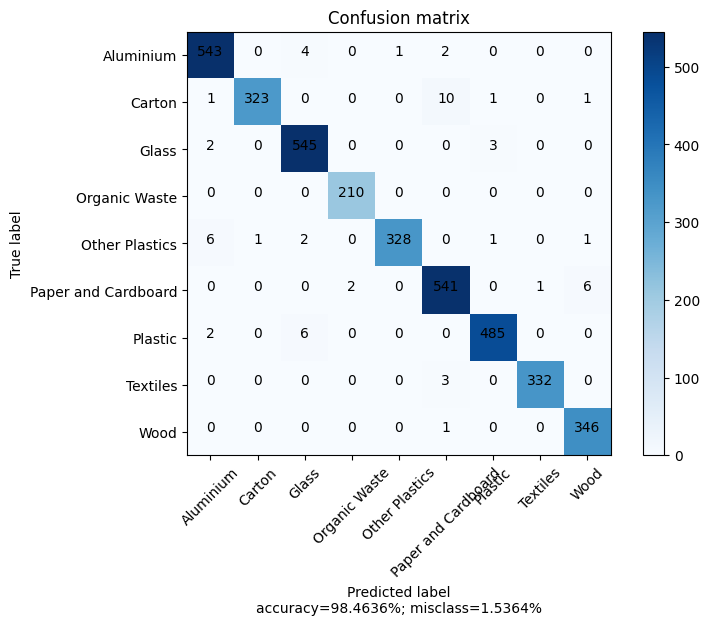

In [ ]:
plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)


In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print('Classification Report : \n' + classification_report(true, predictions))

Classification Report : 
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       550
           1       1.00      0.96      0.98       336
           2       0.98      0.99      0.98       550
           3       0.99      1.00      1.00       210
           4       1.00      0.97      0.98       339
           5       0.97      0.98      0.98       550
           6       0.99      0.98      0.99       493
           7       1.00      0.99      0.99       335
           8       0.98      1.00      0.99       347

    accuracy                           0.98      3710
   macro avg       0.99      0.98      0.99      3710
weighted avg       0.98      0.98      0.98      3710

